# 3. Train model (Tensorflow. Pretrained)

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_VISIBLE_DEVICES"] = ""   # иногда помогает
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
from pathlib import Path
import random

import numpy as np
import pandas as pd
import yaml

import tensorflow as tf

tf.config.set_visible_devices([], "GPU")  # должно сработать только до инициализации
print("Visible devices:", tf.config.get_visible_devices())
print("Physical GPUs:", tf.config.list_physical_devices("CPU"))
from tensorflow import keras

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    accuracy_score,
    matthews_corrcoef,
)


import seaborn as sns
import matplotlib.pyplot as plt

Visible devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Physical GPUs: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Define constants

In [2]:
ROOT = Path(os.path.abspath('')).resolve().parents[0]
FIGURES_PATH = os.path.join(ROOT, 'reports', 'figures')
DATA = os.path.join(ROOT, "data")
PROCESSED_DATA = os.path.join(DATA, "processed") 
INTERIM_DATA = os.path.join(DATA, "interim")
RAW_DATA = os.path.join(DATA, "raw")
FIGURES_PATH = os.path.join(ROOT, 'reports', 'figures')
GARBAGE_CLASSIFICATION_PATH  = os.path.join(RAW_DATA, "garbage_classification")

### Create folders (if they are not exist)

In [3]:
os.makedirs(PROCESSED_DATA, exist_ok=True)
os.makedirs(FIGURES_PATH, exist_ok=True)

### Set random data

In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass

## Load data

### Classes

In [6]:
with open(os.path.join(INTERIM_DATA, "classes.yaml"), "r") as f:
    classes = yaml.safe_load(f)

classes

{1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}

### Datasets

In [7]:
df_train = pd.read_parquet(os.path.join(INTERIM_DATA, "df_train.parquet.gzip"))
df_val = pd.read_parquet(os.path.join(INTERIM_DATA, "df_val.parquet.gzip"))
df_test = pd.read_parquet(os.path.join(INTERIM_DATA, "df_test.parquet.gzip"))

## Transformations

For first iteration, let us not apply any transformations

In [8]:
input_size = 200

# ImageNet normalization values (same as torchvision)
mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
std = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

def preprocess_image(path: tf.Tensor, label: tf.Tensor, training: bool):
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0, 1]
    img = tf.image.resize(img, [input_size, input_size], method="bilinear")

    # Keep "pretrained" pipeline close to torchvision: ToTensor() + Normalize(mean, std)
    img = (img - mean) / std

    return img, tf.cast(label, tf.int32)

## Create datasets

In [9]:
class GarbageSequence(keras.utils.Sequence):
    def __init__(self, df, batch_size=32, training=False, seed=42, shuffle=True):
        self.paths = df["image_path"].astype(str).values
        self.labels = df["class_idx"].astype(int).values
        self.batch_size = batch_size
        self.training = training
        self.rng = np.random.default_rng(seed)
        self.shuffle = shuffle and training
        self.indexes = np.arange(len(self.paths))
        if self.shuffle:
            self.rng.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.paths) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            self.rng.shuffle(self.indexes)

    def __getitem__(self, idx):
        batch_idx = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_paths = self.paths[batch_idx]
        batch_labels = self.labels[batch_idx]

        imgs = []
        for p, y in zip(batch_paths, batch_labels):
            img, _ = preprocess_image(tf.constant(p), tf.constant(y), training=self.training)
            imgs.append(img.numpy())

        return np.stack(imgs, axis=0), batch_labels

In [10]:
train_ds = GarbageSequence(df_train, batch_size=32, training=True, seed=seed)
val_ds   = GarbageSequence(df_val, batch_size=32, training=False)
test_ds = GarbageSequence(df_test, batch_size=32, training=False)

## Model

Function for setting up the appropriate model's device:

In [11]:
@tf.keras.saving.register_keras_serializable(package="garbage")
class GarbageClassificationPretrained(tf.keras.Model):
    def __init__(self, num_classes: int = 6, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = int(num_classes)

        # Backbone
        self.backbone = tf.keras.applications.ResNet50(
            include_top=False,
            weights="imagenet",
            input_shape=(input_size, input_size, 3),
            pooling="avg",
        )
        # Classification head (logits)
        self.classifier = tf.keras.layers.Dense(self.num_classes)

    def call(self, x, training=False):
        x = self.backbone(x, training=training)
        x = self.classifier(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({"num_classes": self.num_classes})
        return config

In [12]:
def get_device() -> str:
    cpus = tf.config.list_physical_devices("CPU")
    gpus = tf.config.list_physical_devices("GPU")
    if len(cpus) > 0:
        return "CPU"
    if len(gpus) > 0:
        return "GPU"
    return "CPU"

In [13]:
device = get_device()
print("Device:", device)

Device: CPU


## Criterion and optimizer

In [14]:
num_classes = int(df_train["class_idx"].nunique())

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# AdamW = closest to PyTorch "Adam + weight_decay"
optimizer = keras.optimizers.AdamW(
    learning_rate=1e-3,
    weight_decay=1e-4,
)

## Train and evaluate model

In order to make it reusable, move the logic of model's training and evaluation to separate function:

In [15]:
def train_eval_model(
    model: keras.Model,
    num_epochs: int,
    best_model_path: str,
    optimizer: keras.optimizers.Optimizer,
    loss_fn,
    class_weight: dict | None = None,
    use_scheduler: bool = False,
):
    callbacks = []

    # Save best model (monitor val_accuracy, like in the PyTorch notebook)
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        filepath=best_model_path,
        save_best_only=True,
        monitor="val_accuracy",
        mode="max",
        verbose=1,
    )
    callbacks.append(checkpoint_cb)

    # ReduceLROnPlateau on val_loss (similar idea to PyTorch scheduler section)
    if use_scheduler:
        reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=2,
            verbose=1,
            mode="min",
            min_lr=1e-7,
        )
        callbacks.append(reduce_lr_cb)

    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=["accuracy"],
        run_eagerly=True,
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=num_epochs,
        callbacks=callbacks,
        class_weight=class_weight,
        verbose=1,
    )

    df_history = pd.DataFrame(history.history)
    df_history["epoch"] = np.arange(len(df_history))
    return df_history

In [ ]:
model = GarbageClassificationPretrained(num_classes=num_classes)
best_model_path = os.path.join(PROCESSED_DATA, "best_model_pretrained.keras")

In [17]:
df_train_val = train_eval_model(
    model=model,
    num_epochs=20,
    best_model_path=best_model_path,
    optimizer=optimizer,
    loss_fn=loss_fn,
)

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 1.2733 - accuracy: 0.5928
Epoch 1: val_accuracy improved from -inf to 0.19817, saving model to /Users/vadim.sokoltsov/learning/bin-it-right/data/processed/best_model_pretrained.keras
56/56 [==============================] - 176s 3s/step - loss: 1.2733 - accuracy: 0.5928 - val_loss: 6.9326 - val_accuracy: 0.1982
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 0.8470 - accuracy: 0.6878
Epoch 2: val_accuracy did not improve from 0.19817
56/56 [==============================] - 179s 3s/step - loss: 0.8470 - accuracy: 0.6878 - val_loss: 8.8307 - val_accuracy: 0.1463
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 0.5409 - accuracy: 0.8060
Epoch 3: val_accuracy improved from 0.19817 to 0.29878, saving model to /Users/vadim.sokoltsov/learning/bin-it-right/data/processed/best_model_pretrained.keras
56/56 [==============================] - 181s 3s/step - loss: 0.5409 - accuracy: 0.8060 - 

### Observe results

In [18]:
df_train_val.head(10)

,loss,accuracy,val_loss,val_accuracy,epoch
0,1.273348,0.592760,6.932604,0.198171,0
1,0.847005,0.687783,8.830738,0.146341,1
2,0.540922,0.805995,2.210508,0.298781,2
3,0.375152,0.866516,1.972738,0.189024,3
4,0.294094,0.902149,3.510327,0.128049,4
5,0.250703,0.915158,3.965946,0.134146,5
6,0.143970,0.951923,4.389532,0.164634,6
7,0.162235,0.951923,6.778355,0.179878,7
8,0.283515,0.902715,9.482566,0.216463,8
9,0.216863,0.925905,6.463775,0.259146,9


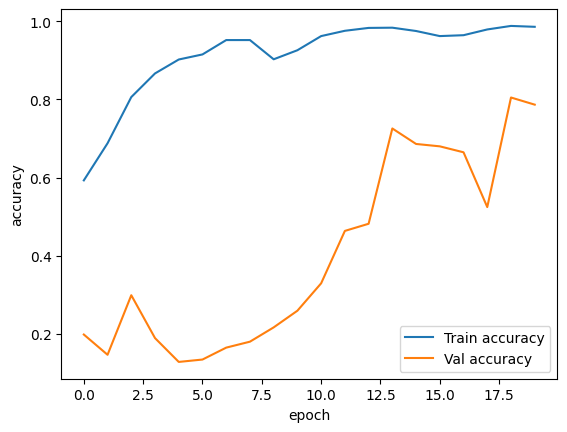

In [19]:
sns.lineplot(data=df_train_val, x='epoch', y='accuracy', label='Train accuracy')
sns.lineplot(data=df_train_val, x='epoch', y='val_accuracy', label='Val accuracy')
plt.savefig(
    os.path.join(FIGURES_PATH, "tensorflow_pretrained_accuracy_default.png")
)
plt.show()

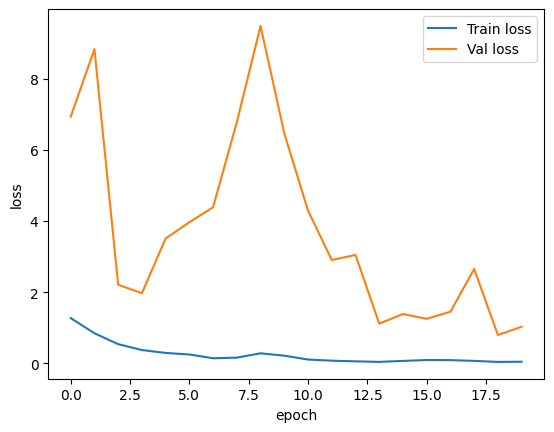

In [20]:
sns.lineplot(data=df_train_val, x='epoch', y='loss', label='Train loss')
sns.lineplot(data=df_train_val, x='epoch', y='val_loss', label='Val loss')
plt.savefig(
    os.path.join(FIGURES_PATH, "tensorflow_pretrained_loss_default.png")
)
plt.show()

## Test model

In [ ]:
from typing import Dict, List

def test_model(model: keras.Model, dataset) -> Dict[str, np.ndarray]:
    all_labels = []
    for images, labels in dataset:
        all_labels.extend(labels)
    all_labels = np.array(all_labels)
    
    predictions = model.predict(dataset)
    pred_labels = np.argmax(predictions, axis=1)

    return {
        'labels': all_labels,
        'preds': pred_labels
    }

In [22]:
best_model = tf.keras.models.load_model(
    best_model_path,
    custom_objects={"GarbageClassificationPretrained": GarbageClassificationPretrained},
    compile=False,
)

test_data = test_model(model=best_model, dataset=test_ds)

14/14 [==============================] - 8s 548ms/step


In [23]:
y_true = test_data["labels"]
y_pred = test_data["preds"]

metrics = {
    "accuracy": accuracy_score(y_true, y_pred),
    "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
    "macro_f1": f1_score(y_true, y_pred, average="macro"),
    "weighted_f1": f1_score(y_true, y_pred, average="weighted"),
    "micro_f1": f1_score(y_true, y_pred, average="micro"),
    "macro_precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
    "macro_recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
    "mcc": matthews_corrcoef(y_true, y_pred),
}

for k, v in metrics.items():
    print(f"{k:>18}: {v:.4f}")

          accuracy: 0.7865
 balanced_accuracy: 0.7631
          macro_f1: 0.7716
       weighted_f1: 0.7829
          micro_f1: 0.7865
   macro_precision: 0.7948
      macro_recall: 0.7631
               mcc: 0.7396


In [24]:
print("Classification report:")
print(classification_report(test_data["labels"], test_data["preds"], digits=3))

Classification report:
              precision    recall  f1-score   support

           0      0.824     0.683     0.747        82
           1      0.772     0.907     0.834       108
           2      0.776     0.943     0.852        70
           3      0.864     0.689     0.767        74
           4      0.714     0.735     0.725        68
           5      0.818     0.621     0.706        29

    accuracy                          0.787       431
   macro avg      0.795     0.763     0.772       431
weighted avg      0.792     0.787     0.783       431



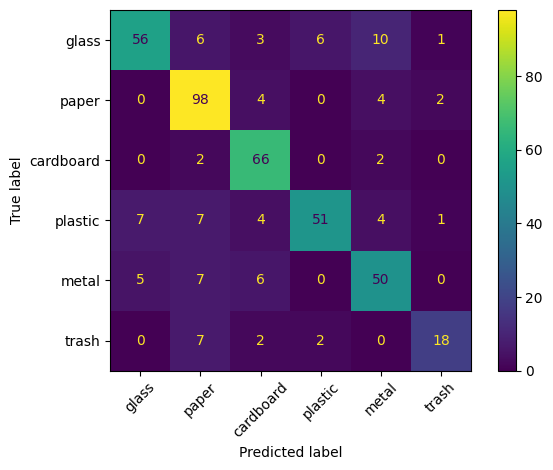

In [25]:
cm = confusion_matrix(test_data["labels"], test_data["preds"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(classes.values()))
fig = disp.plot(xticks_rotation=45)
fig.figure_.tight_layout()
fig.figure_.savefig(os.path.join(FIGURES_PATH, "tensorflow_pretrained_confusion_matrix_default.png"))
plt.show()

In [26]:
class_counts = df_train["class_idx"].value_counts().sort_index()
alpha = 0.5
class_weights = (1.0 / class_counts) ** alpha
class_weights = class_weights / class_weights.mean()

# Keras expects a dict: {class_index: weight}
class_weight_dict = {int(k): float(v) for k, v in class_weights.items()}
class_weight_dict

{0: 0.8400109655434669,
 1: 0.7872887821364266,
 2: 0.9329226517313789,
 3: 0.8484413943384788,
 4: 0.93455221219026,
 5: 1.6567839940599893}

### Observations

* Overall good `accuracy`
* `Trash` dataclass detection

## Tune model

In [27]:
from tensorflow.keras.applications.resnet50 import preprocess_input

input_size = 200

def preprocess_image(path: tf.Tensor, label: tf.Tensor, training: bool):
    # 1) read + decode
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_bytes, channels=3)
    img = tf.image.resize(img, [input_size, input_size], method="bilinear")

    img = tf.image.convert_image_dtype(img, tf.float32)

    # 3) augmentations (train only)
    if training:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, lower=0.9, upper=1.1)

    # 4) ResNet preprocess expects values in [0..255]
    img = img * 255.0
    img = preprocess_input(img)

    return img, tf.cast(label, tf.int32)

In [28]:
@tf.keras.saving.register_keras_serializable(package="garbage")
class GarbageClassificationPretrained(tf.keras.Model):
    def __init__(self, num_classes: int = 6, dropout: float = 0.3, head_units: int = 256, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = int(num_classes)
        self.dropout = float(dropout)
        self.head_units = int(head_units)

        # Backbone (ImageNet)
        self.backbone = tf.keras.applications.ResNet50(
            include_top=False,
            weights="imagenet",
            input_shape=(input_size, input_size, 3),
            pooling="avg",
        )

        # Stronger head (logits)
        self.classifier = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(self.head_units),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Activation("relu"),
                tf.keras.layers.Dropout(self.dropout),
                tf.keras.layers.Dense(self.num_classes),
            ],
            name="classifier",
        )

    def call(self, x, training=False):
        x = self.backbone(x, training=False)
        x = self.classifier(x, training=training)
        return x

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "num_classes": self.num_classes,
                "dropout": self.dropout,
                "head_units": self.head_units,
            }
        )
        return config

In [29]:
def train_eval_model(
    model: keras.Model,
    num_epochs: int,
    best_model_path: str,
    optimizer: keras.optimizers.Optimizer,
    loss_fn,
    class_weight: dict | None = None,
    use_scheduler: bool = False,
    use_early_stopping: bool = False
):
    callbacks = []

    # Save best model (monitor val_accuracy, like in the PyTorch notebook)
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        filepath=best_model_path,
        save_best_only=True,
        monitor="val_loss",
        mode="min",
        save_weights_only=True,
        verbose=1,
    )
    callbacks.append(checkpoint_cb)

    # ReduceLROnPlateau on val_loss (similar idea to PyTorch scheduler section)
    if use_scheduler:
        reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=2,
            verbose=1,
            mode="min",
            min_lr=1e-7,
        )
        callbacks.append(reduce_lr_cb)
    
    if use_early_stopping:
        early_stop_cb = keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            min_delta=1e-4,
            restore_best_weights=True,
            verbose=1,
        )
        callbacks.append(early_stop_cb)

    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=["accuracy"],
        run_eagerly=True,
        jit_compile=False,
        steps_per_execution=1
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=num_epochs,
        callbacks=callbacks,
        class_weight=class_weight,
        verbose=1,
    )

    df_history = pd.DataFrame(history.history)
    df_history["epoch"] = np.arange(len(df_history))
    return df_history

In [30]:
model_tune = GarbageClassificationPretrained(num_classes=num_classes)
best_model_path_tuned_stage_1 = os.path.join(PROCESSED_DATA, "best_model_pretrained_tuned_stage_1.weights.h5")
optimizer = keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
model_tune.backbone.trainable = False
_ = model_tune(tf.zeros([1, input_size, input_size, 3]), training=False)
optimizer.build(model_tune.trainable_variables)

In [31]:
df_train_val_weighted = train_eval_model(
    model=model_tune,
    num_epochs=20,
    best_model_path=best_model_path_tuned_stage_1,
    optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
    loss_fn=loss_fn,
    class_weight=class_weight_dict,
    use_scheduler=True,
    use_early_stopping=True
)

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 1.3516 - accuracy: 0.4627
Epoch 1: val_loss improved from inf to 9.17881, saving model to /Users/vadim.sokoltsov/learning/bin-it-right/data/processed/best_model_pretrained_tuned_stage_1.weights.h5
56/56 [==============================] - 165s 3s/step - loss: 1.3516 - accuracy: 0.4627 - val_loss: 9.1788 - val_accuracy: 0.2683 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.1427 - accuracy: 0.5317
Epoch 2: val_loss improved from 9.17881 to 8.26005, saving model to /Users/vadim.sokoltsov/learning/bin-it-right/data/processed/best_model_pretrained_tuned_stage_1.weights.h5
56/56 [==============================] - 169s 3s/step - loss: 1.1427 - accuracy: 0.5317 - val_loss: 8.2601 - val_accuracy: 0.1951 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.0891 - accuracy: 0.5639
Epoch 3: val_loss improved from 8.26005 to 5.53894, saving model to /Users/vadim.sokol

In [32]:
best_model_path_tuned_stage2 = os.path.join(PROCESSED_DATA, "best_model_pretrained_tuned_stage2.weights.h5")

model_tune.backbone.trainable = True

for layer in model_tune.backbone.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

optimizer2 = keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4)

_ = model_tune(tf.zeros([1, input_size, input_size, 3]), training=False)
optimizer2.build(model_tune.trainable_variables)

df_train_val_weighted = train_eval_model(
    model=model_tune,
    num_epochs=20,
    best_model_path=best_model_path_tuned_stage2,
    optimizer=optimizer2,
    loss_fn=loss_fn,
    class_weight=class_weight_dict,
    use_scheduler=True,
    use_early_stopping=True
)

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 1.3251 - accuracy: 0.4542
Epoch 1: val_loss improved from inf to 9.47591, saving model to /Users/vadim.sokoltsov/learning/bin-it-right/data/processed/best_model_pretrained_tuned_stage2.weights.h5
56/56 [==============================] - 173s 3s/step - loss: 1.3251 - accuracy: 0.4542 - val_loss: 9.4759 - val_accuracy: 0.2530 - lr: 1.0000e-04
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.0675 - accuracy: 0.5532
Epoch 2: val_loss improved from 9.47591 to 2.69993, saving model to /Users/vadim.sokoltsov/learning/bin-it-right/data/processed/best_model_pretrained_tuned_stage2.weights.h5
56/56 [==============================] - 173s 3s/step - loss: 1.0675 - accuracy: 0.5532 - val_loss: 2.6999 - val_accuracy: 0.2774 - lr: 1.0000e-04
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 0.9111 - accuracy: 0.6131
Epoch 3: val_loss improved from 2.69993 to 1.38585, saving model to /Users/vadim

In [33]:
best_model = GarbageClassificationPretrained(num_classes=num_classes)
_ = best_model(tf.zeros([1, input_size, input_size, 3]), training=False)

best_model.load_weights(best_model_path_tuned_stage2)


test_data = test_model(model=best_model, dataset=test_ds)

14/14 [==============================] - 8s 530ms/step


In [34]:
y_true = test_data["labels"]
y_pred = test_data["preds"]

metrics = {
    "accuracy": accuracy_score(y_true, y_pred),
    "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
    "macro_f1": f1_score(y_true, y_pred, average="macro"),
    "weighted_f1": f1_score(y_true, y_pred, average="weighted"),
    "micro_f1": f1_score(y_true, y_pred, average="micro"),
    "macro_precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
    "macro_recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
    "mcc": matthews_corrcoef(y_true, y_pred),
}

for k, v in metrics.items():
    print(f"{k:>18}: {v:.4f}")

          accuracy: 0.8492
 balanced_accuracy: 0.8492
          macro_f1: 0.8427
       weighted_f1: 0.8498
          micro_f1: 0.8492
   macro_precision: 0.8394
      macro_recall: 0.8492
               mcc: 0.8155


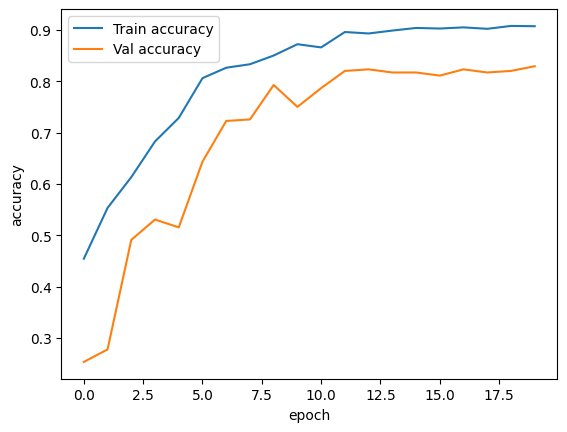

In [38]:
sns.lineplot(data=df_train_val_weighted, x='epoch', y='accuracy', label='Train accuracy')
sns.lineplot(data=df_train_val_weighted, x='epoch', y='val_accuracy', label='Val accuracy')
plt.savefig(
    os.path.join(FIGURES_PATH, "tensorflow_pretrained_accuracy_tuned.png")
)
plt.show()

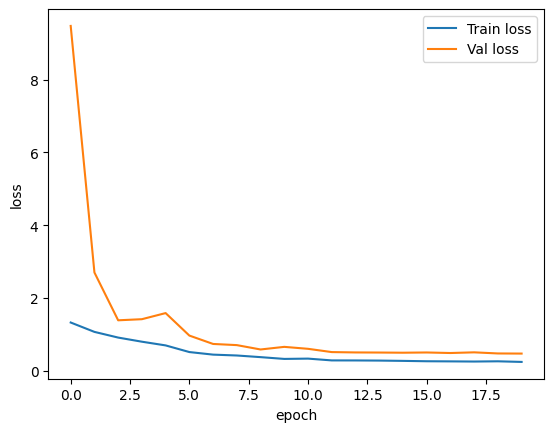

In [39]:
sns.lineplot(data=df_train_val_weighted, x='epoch', y='loss', label='Train loss')
sns.lineplot(data=df_train_val_weighted, x='epoch', y='val_loss', label='Val loss')
plt.savefig(
    os.path.join(FIGURES_PATH, "tensorflow_pretrained_loss_tuned.png")
)
plt.show()

In [35]:
print("Classification report:")
print(classification_report(test_data["labels"], test_data["preds"], digits=3))

Classification report:
              precision    recall  f1-score   support

           0      0.774     0.793     0.783        82
           1      0.909     0.926     0.917       108
           2      0.953     0.871     0.910        70
           3      0.781     0.770     0.776        74
           4      0.877     0.838     0.857        68
           5      0.743     0.897     0.812        29

    accuracy                          0.849       431
   macro avg      0.839     0.849     0.843       431
weighted avg      0.852     0.849     0.850       431



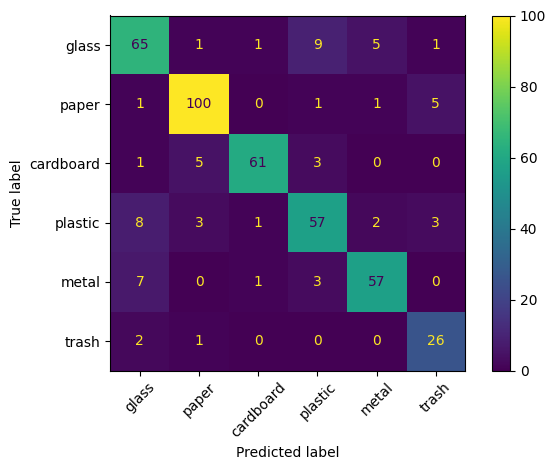

In [36]:
cm_tuned = confusion_matrix(test_data["labels"], test_data["preds"])
disp_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_tuned, display_labels=list(classes.values()))
fig = disp_tuned.plot(xticks_rotation=45)
fig.figure_.tight_layout()
fig.figure_.savefig(os.path.join(FIGURES_PATH, "tensorflow_pretrained_confusion_matrix_tuned.png"))
plt.show()

#### Observations

* After freezing `BatchNormalization` layers, it became possible to achive better accuracy